# 16 Getting flux limits from the API
## Flux limits for a shot

After installing the HETDEX API we can import the tools to access the flux limits

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

from hetdex_api.survey import Survey
from hetdex_api.flux_limits.shot_sensitivity import ShotSensitivity

# has to be here, as SensitivityCube sets a backend
%matplotlib inline

In [59]:
from numpy import linspace, ones

In [34]:
from numpy.random import uniform

To start we need to pick a datevobs. Let's use the survey table, as described in the first notebook.

In [5]:
survey = Survey("hdr2.1")
survey_table = survey.return_astropy_table()
survey_table[-10:]

shotid,field,objid,date,obsid,ra,dec,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,ambtemp,datevobs,dewpoint,exptime,humidity,mjd,nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra,shot_flag,fluxlimit_4540
int64,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,bytes12,float32,float32,float32,float32,int32,int32,float32,float32,bytes7,float32,float32,float32,bool,float64
20200625017,dex-spring,DEXsp4017,20200625,17,210.738079,54.380782,299.624902,70,2.7147236,0.7351299,0.0657,19.393888,20200625v017,8.528889,427.93527,46.422,59025.22,140,1,804.5381,323.24152,0517466,54.38,297.93137,210.738,True,3.4022886355000006e-16
20200625018,dex-spring,DEXsp3967,20200625,18,220.267192,53.446167,299.593584,70,1.9157426,0.565008,0.1493,19.396667,20200625v018,8.218889,607.68256,46.019,59025.24,16,1,804.5381,323.24152,0545172,53.446377,297.93137,220.26654,True,1.0518607855000001e-16
20200625019,dex-spring,DEXsp7185,20200625,19,231.379347,53.476017,299.621378,70,1.9826775,0.25718248,0.1344,19.47,20200625v019,7.553889,367.87448,42.96,59025.266,27,1,804.301,323.24152,0621492,53.475475,297.93137,231.37999,True,9.963181855e-17
20200625020,dex-spring,DEXsp6525,20200625,20,234.140324,53.98981,299.617724,70,1.8120736,0.32785416,0.1523,19.15611,20200625v020,7.5394444,487.69955,43.635,59025.28,37,1,804.301,323.24152,0645237,53.989723,297.93137,234.13976,True,9.209148355000002e-17
20200625021,dex-spring,DEXsp6671,20200625,21,240.172723,53.54772,299.621378,70,1.6585162,0.38814068,0.1324,19.146667,20200625v021,7.551111,488.26645,43.714,59025.3,21,1,804.3688,323.24152,0715209,53.547062,297.93137,240.1725,True,9.047872855000001e-17
20200626016,dex-spring,DEXsp7175,20200626,16,230.675762,53.234764,296.974196,71,1.2604536,0.10521854,0.1537,20.10389,20200626v016,9.031111,427.66614,46.533,59026.246,43,1,804.6397,321.002,0554075,53.234367,295.3104,230.67612,True,5.863015855000002e-17
20200626017,dex-spring,DEXsp7111,20200626,17,224.852859,53.549799,296.932937,71,1.3909405,0.2306041,0.1123,19.631666,20200626v017,9.708889,367.5492,49.958,59026.266,25,1,804.7074,321.002,0622044,53.549393,295.3104,224.85326,True,7.762371355000001e-17
20200626018,dex-spring,DEXsp6508,20200626,18,233.651753,53.993989,296.924724,71,1.4448333,0.23766221,0.1245,19.502777,20200626v018,10.167222,367.12317,51.678,59026.28,38,1,804.7074,321.00192,0647072,53.993607,295.3103,233.65271,True,7.803667855000001e-17
20200626019,dex-spring,DEXsp6618,20200626,19,239.174074,53.113723,296.973253,71,1.3604825,0.2726477,0.1043,19.17389,20200626v019,11.966666,367.45407,53.376,59026.3,27,1,804.6397,321.00192,0711352,53.113827,295.3103,239.17342,True,8.676019855000001e-17


Let pick datevobs ``20190209v024`` and an S/N cut of 5.0 as an example.

In [36]:
datevobs = "20190209v024"
sncut = 5.0

You can specify a `flim_model`. This sets the scaling between the noise from the fibers and the completeness. The current version is `v1`. If you leave this out it will default to the latest version.

In [33]:
shot_sens_v1 = ShotSensitivity(datevobs, flim_model="v1")

We can use the `TangentPlane` object in the `ShotSensitivity` class to generate some points in the focal plane just to give us some ra/dec values to generate limits for. Here `x` and `y` are arcseconds in the focal plane.

In [48]:
x = uniform(-600., 600.0, 2000)
y = uniform(-600., 600.0, 2000)
wave = uniform(3700, 5400, 2000)
ra, dec = shot_sens_v1.tp.xy2raDec(x, y)

Find the flux at 50\% completeness.

In [49]:
f50 = shot_sens_v1.get_f50(ra, dec, wave, sncut)

100%|██████████| 14170/14170 [00:00<00:00, 99526.07it/s] 


Select points with sensible flux limits (i.e. falling in IFUs and not masked)

In [50]:
ra = ra[f50 < 1e-10]
dec = dec[f50 < 1e-10]
wave = wave[f50 < 1e-10]
f50 = f50[f50 < 1e-10]

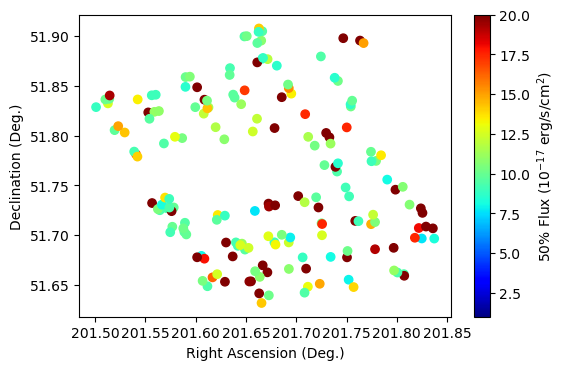

In [52]:
plt.figure(dpi=100)
plt.scatter(ra, dec, c=f50*1e17, vmin = 1, vmax = 20, cmap="jet")
plt.xlabel("Right Ascension (Deg.)")
plt.ylabel("Declination (Deg.)")
plt.colorbar(label="50% Flux (10$^{-17}$ erg/s/cm$^2$)")

Text(0, 0.5, 'Flux limit ($10^{-17}$ erg/s/cm$^2$)')

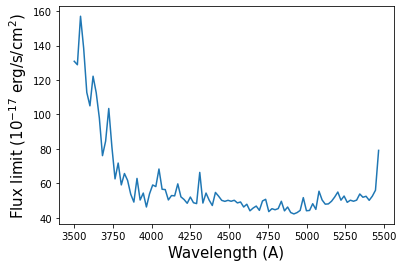

In [63]:
wls = linspace(3500.0, 5505.0, 100)
print(flims[50])
flims = shot_sens_v1.get_f50(ra[50]*ones(len(wls)), dec[50]*ones(len(wls)), 
                             wls, sncut)
plt.plot(wls[flims < 999], 1e17*flims[flims < 999])
plt.xlabel("Wavelength (A)", fontsize=15.0)
plt.ylabel("Flux limit ($10^{-17}$ erg/s/cm$^2$)", fontsize=15.0)

Or to get not the flux limit but an estimate of the 1 sigma noise in apertures, use the `direct_sigmas` option, i.e. do

In [96]:
one_sigma = shot_sens_v1.get_f50(ra, dec, wave, sncut, direct_sigmas=True)

In [97]:
one_sigma

array([2.25182710e-17, 1.25893340e-16, 2.11942009e-17, 2.34990408e-17,
       5.07440301e-17, 1.96830013e-17, 2.52532940e-17, 1.57535208e-16,
       4.74406708e-17, 3.80091511e-17, 2.06260700e-17, 3.54864245e-17,
       3.73934958e-17, 2.43666579e-17, 2.51545722e-17, 6.64109826e-17,
       1.98839941e-17, 4.16477896e-17, 2.03688300e-17, 2.05957406e-17,
       2.89949847e-17, 2.36745502e-17, 2.32860273e-17, 2.26215562e-17,
       2.72682332e-17, 2.69889666e-17, 2.05226571e-17, 3.57368836e-17,
       2.18163835e-17, 1.93520116e-17, 1.97326239e-17, 2.10326516e-17,
       6.30744400e-17, 2.11570605e-17, 4.44759691e-16, 1.00858617e-16,
       2.96384855e-17, 3.22567118e-16, 3.22033825e-17, 2.02758749e-17,
       2.08706923e-17, 3.12283154e-17, 2.74259210e-17, 2.05976807e-17,
       2.05300595e-17, 2.24236522e-17, 6.05432265e-17, 1.82236426e-16,
       9.35743829e-16, 2.14071626e-17, 9.98931873e-17, 2.04372734e-17,
       1.73799134e-17, 3.91791288e-17, 2.11958849e-17, 2.08696987e-17,
      

## Fraction of detected sources versus flux

To get the fraction of sources detected at a particular flux, rather than just the flux limit value one can use this method

Text(0, 0.5, 'Completeness')

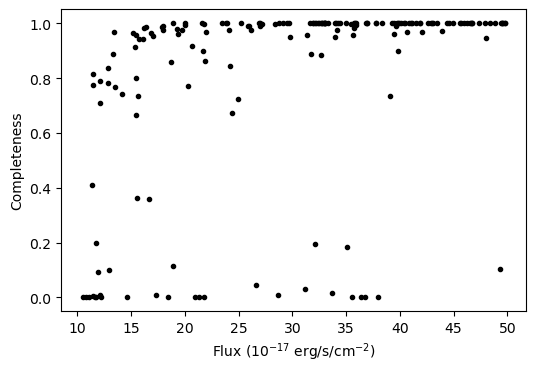

In [78]:
# Flux (cgs) RA DEC (in degrees) Wavelength (Angstrom) 
fluxes = uniform(1e-16, 5e-16, len(ra))
compl = shot_sens_v1.return_completeness(fluxes, ra, dec, wave, sncut)

plt.figure(dpi=100)
plt.plot(fluxes*1e17, compl, "k.")
plt.xlabel("Flux (10$^{-17}$ erg/s/cm$^{-2}$)")
plt.ylabel("Completeness")

By definition the 50\% flux should return 50\% completeness

In [72]:
flux = shot_sens_v1.get_f50(ra[0], dec[0], 4245, sncut)
shot_sens_v1.return_completeness(flux, ra[0], dec[0], 4245, sncut)

100%|██████████| 9/9 [00:00<00:00, 24688.51it/s]


array([0.50000005])

Here is a plot of the completeness versus flux at some position. Note we use the flux limit computed above to define the range of the plot

Text(0, 0.5, 'Detected Fraction')

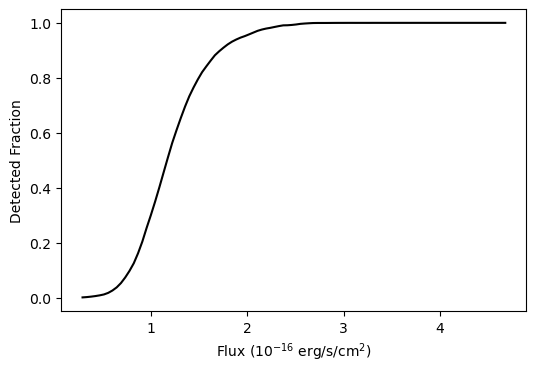

In [81]:
fluxes = linspace(0.25*flux, 4*flux, 100)
compl = shot_sens_v1.return_completeness(fluxes, ra[0], dec[0], 4245, sncut)
plt.figure(dpi=100)
plt.plot(fluxes*1e16, compl, "k-")
plt.xlabel("Flux ($10^{-16}$ erg/s/cm$^2$)")
plt.ylabel("Detected Fraction")

## Generating a cube of flux limits for an IFU

We can extract a 3D cube of precomputed flux limits for an IFU like this. Note that you have to add the string `ifuslot_` to the three digit IFU slot. It's not really recommended that you do this, as it pixelizes the flux limits, but it's included if you want it or for visualisation purposes. The `nx` and `ny` sets the resolution.

In [82]:
scube_dict = {}
for slot in ['096', '085', '033']:
    scube_dict[slot] = shot_sens_hdr2.extract_ifu_sensitivity_cube("ifuslot_{:s}".format(slot), 
                                                                   nx=30, ny=30)

100%|██████████| 172/172 [00:00<00:00, 721.06it/s]


For comparison, here we'll generate the same IFUs but with twice the resolution

In [83]:
scube_dict_hires = {}
for slot in ['096', '085', '033']:
    scube_dict_hires[slot] = shot_sens_hdr2.extract_ifu_sensitivity_cube("ifuslot_{:s}".format(slot), 
                                                                         nx=60, ny=60)

scube_hires = shot_sens_hdr2.extract_ifu_sensitivity_cube("ifuslot_036", nx=60, ny=60)

100%|██████████| 180/180 [00:01<00:00, 140.25it/s]


The ``sigmas`` array is now a ``numpy.ma:MaskedArray`` which contains both a data array and a mask array

In [85]:
scube_dict['096'].sigmas.data[:3, :3, :3]

array([[[1.998e-14, 1.998e-14, 1.998e-14],
        [1.998e-14, 1.998e-14, 1.998e-14],
        [1.998e-14, 1.998e-14,       nan]],

       [[1.998e-14, 1.998e-14, 1.998e-14],
        [1.998e-14, 1.998e-14, 1.998e-14],
        [1.998e-14, 1.998e-14,       nan]],

       [[1.998e-14, 1.998e-14, 1.998e-14],
        [1.998e-14, 1.998e-14, 1.998e-14],
        [1.998e-14, 1.998e-14,       nan]]])

In [87]:
scube_dict['096'].sigmas.mask[0, :3, :3]

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

Lets plot the low res and high res flux limit cubes to compare

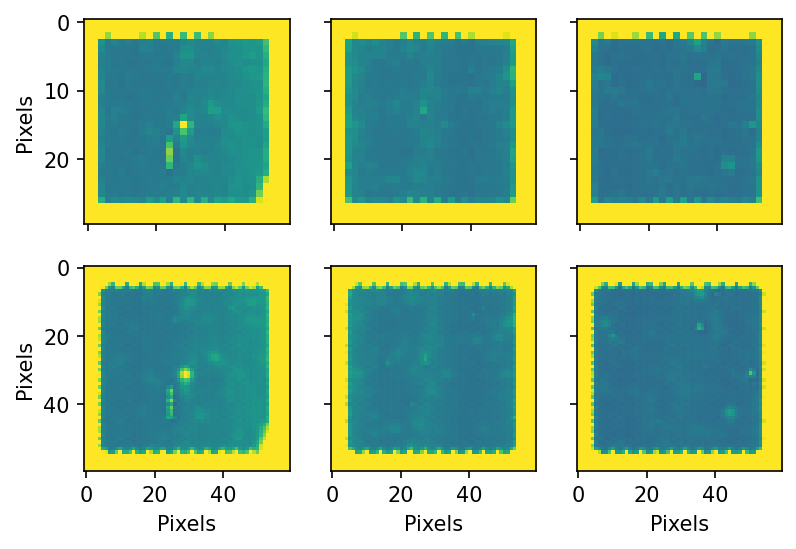

In [93]:
fig = plt.figure(dpi=150)
vrange=[5e-18, 5e-17]
gs = fig.add_gridspec(nrows=2, ncols=3)

for i, slot in enumerate(['096', '085', '033']):

    ax = fig.add_subplot(gs[0,i])
    ax.imshow(scube_dict[slot].sigmas[500, :, :], clim=vrange)
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Pixels")
    ax.label_outer()

    ax = fig.add_subplot(gs[1,i])
    ax.imshow(scube_dict_hires[slot].sigmas[500, :, :], clim=vrange)
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Pixels")
    ax.label_outer()

The iteration over IFUs is also still possible.